# Feasibility study 

Here we are gonna explore if it is feasible to run Bayesian optimization in the context of oprimizing 3D-printing of cdECM-NP material.

We are going to assume that we have 3 input parameters: 
- speed, 
- pressure, 
- needle gauge.

And we are optimizing for 1 output parameter:
- material accuracy.

We also assume that we have previously conducted the full-factorial study with **8 initial datapoints** - we use this to initialize the bayesian optimizer.

We assume we are going to run the experiment until convergence (best case scenario).

We will monitor how much time the iterations take (in case we have to hard-code the number of iterations needed). 


### Discussion 10/14

For the parameters - establish upper and lower bounds.

- speed: [0.5 - 2] mm/s
- pressure: [10 - 50] psi
- needle gauge: {18, 20, 22}

Step sizes:
- speed: 0.2 mm/s
- pressure: 1 psi

-> discrete optimizer

Plot time - number of datapoints

Marissa - full factorial and initial dataset

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import gpflow
import trieste

from time import time, sleep
import random

from trieste.ask_tell_optimization import AskTellOptimizer
from trieste.bayesian_optimizer import Record
from trieste.data import Dataset
from trieste.models.gpflow.models import GaussianProcessRegression
from trieste.objectives.utils import mk_observer
from trieste.observer import OBJECTIVE
from trieste.space import DiscreteSearchSpace
from util.plotting import plot_function_2d, plot_bo_points

np.random.seed(1234)
tf.random.set_seed(1234)

### Important parameters of the algorithm:

**Gaussian Process parameters:**

1. **Kernel function** (below the choice is given as a Matern52, but it could be many other kernels). In the presentation linked in the theoretical part they show how the nature of functions described with the gaussian process is dfined by a kernel. So this is really a key parameter, as seen [here](https://gpflow.readthedocs.io/en/v1.5.1-docs/notebooks/advanced/kernels.html):


<img src="Kernels.PNG" width="400"/>

2. **Kernel hyperparameters** the kernels themselves also have certain parameters that can be changes and will inflience the "look" of the functions. 

3. **Additional things to think about when formulating the Gaussian Process** with a diagram given here: https://nbviewer.org/github/GPflow/GPflow/blob/develop-1.0/doc/source/notebooks/GPflows.png

**Acquisition function parameters:**

Different acquisition functions have different trade-offs between exploration and exploitation (going to the maximum of the function VS exploring unvisited spaces). They also have their own hyper parameters that could be tweeked.

DiscreteThompsonSampling is one acquisition rule that is picked here. Others options could be EfficientGlobalOptimization with any of the standard acquisition functions such as expected improvement etc. 

The acquisition function will influence how the new evidence points are suggested.

In [2]:
def build_model(data, kernel_func=None):
    """kernel_func should be a function that takes variance as a single input parameter"""
    variance = tf.math.reduce_variance(data.observations)
    if kernel_func is None:
        kernel = gpflow.kernels.Matern52(variance=variance)
    else:
        kernel = kernel_func(variance)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    # I am not sure why we set the gpr.likelihood to false here :/ 
    #gpflow.set_trainable(gpr.likelihood, False)

    return GaussianProcessRegression(gpr)

def plot_ask_tell_results(ask_tell_result):
    dataset = ask_tell_result.try_get_final_dataset()
    query_points = dataset.query_points.numpy()
    observations = dataset.observations.numpy()
    fig, ax = plt.subplots(1,3,figsize=(10,5))

    sc = ax[0].scatter(query_points[:, 0], query_points[:,1], c=observations)
    ax[0].set_ylabel('Speed')
    ax[0].set_xlabel('Needle')
    
    sc = ax[1].scatter(query_points[:, 0], query_points[:,2], c=observations)
    ax[1].set_ylabel('Pressure')
    ax[1].set_xlabel('Needle')
    
    sc = ax[2].scatter(query_points[:, 1], query_points[:,2], c=observations)
    ax[2].set_ylabel('Pressure')
    ax[2].set_xlabel('Speed')
    
    cbar = fig.colorbar(sc)
    cbar.set_label("Material Accuracy", loc='top')

    plt.show()

## Our search-space has at least 3 dimensions

In [3]:
import itertools as it

In [4]:
# set up the limits for speed
speed_up = 2
speed_down = 0.5 
speed_step = 0.2

# set up the limits for pressure
pressure_up = 50
pressure_down = 10
pressure_step = 1

# set up the arrays of values within the limits
needle_values = np.array([18.0, 20.0, 22.0], dtype=np.float64)

# (fancy use of np.array and start, stop, step arguments)
speed_values = np.arange(start = speed_down, stop = speed_up, step = speed_step ,dtype=np.float64)
pressure_values = np.arange(start = pressure_down, stop = pressure_up, step = pressure_step, dtype=np.float64)

# print (TODO: check what to do with edgecases - such as 1.9 for speed)
print("Needle values: {}".format(needle_values))
print("Speed values: {}".format(speed_values))
print("Pressure values: {}".format(pressure_values))

'''
# define the search spaces
needle_space = DiscreteSearchSpace(needle_values)
speed_space = DiscreteSearchSpace(speed_values)
pressure_space = DiscreteSearchSpace(pressure_values)

# combined search space - cartesian product of the existing arrays
# I thought using this function: needle_space.product(speed_space) - but it is not implemented
# instead - using itertools cartesian product
'''
all_combinations = np.array(list(it.product(needle_values, speed_values, pressure_values)))
search_space = DiscreteSearchSpace(all_combinations)

Needle values: [18. 20. 22.]
Speed values: [0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9]
Pressure values: [10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.
 46. 47. 48. 49.]


In [5]:
# define our 3D search space
'''
For the parameters - establish upper and lower bounds.

speed: [0.5 - 2] mm/s
pressure: [10 - 50] psi
needle gauge: {18, 20, 22}

Step sizes:
speed: 0.2 mm/s
pressure: 1 psi
'''

# no longer continuous box search space
#search_space = Box([0.5, 10, 18], [2, 50, 22])

# we have 8 initial points that cover the lowest and the highest possible printing values
num_initial_points = 8

# this is still random
initial_x = np.array([[18,0.5,10], 
                 [18,0.7,11], 
                 [18,0.9,12], 
                 [20,1.1,13], 
                 [20,1.3,20], 
                 [20,1.5,30], 
                 [21,1.7,40], 
                 [21,1.9,35]
            ])

initial_y = np.array([[0.384], [0.462], [0.768], [0.332], [0.738], [0.462], [0.207], [0.127]])

initial_data = trieste.data.Dataset(
    tf.constant(initial_x, dtype ='float64'), 
    tf.constant(initial_y, dtype ='float64'))


In [6]:
# we initialize the Thompson Sampling which will tell us which point to choose next
acq_rule = trieste.acquisition.rule.DiscreteThompsonSampling(
    num_search_space_samples=800, num_query_points=1
)

In [7]:
%time

# we initialize the gaussian process with this data
model = build_model(initial_data)
# we formulate the ask-tell optimizer
ask_tell = AskTellOptimizer(search_space, initial_data, model, acq_rule)

Wall time: 0 ns


In [ ]:
%time
max_iterations = 1000
times_dict = {"num_data":[], "ask_time":[], "tell_time":[]}
num_datapoints = initial_x.shape[0]
for i in range(max_iterations):
    print("Iteration #{}".format(i))
    print("Ask Trieste for configuration")
    t1 = time()
    new_config = ask_tell.ask()
    t2 = time()
    ask_time = t2-t1
    
    print("Trieste took {:.2f}s to answer".format(t2-t1))
    for j in range(len(new_config)):
        print('New Configuration to Try #', i + 1)
        speed = np.round(new_config[j][0].numpy(),1)
        pressure =  np.round(new_config[j][1].numpy(),1)
        ng =  np.round(new_config[j][2].numpy(),1)
        print('Speed (mm/s): ', speed)
        print('Pressure (bars): ', pressure, '\n')
        print('Needle (mm): ', ng, '\n')
        
    plot_ask_tell_results(ask_tell.to_result())
    
    # "dummy" printing parameters here (random)
    printed_material_accuracy = random.random()
    print("Printed material accuracy of {}".format(printed_material_accuracy))
    
    new_input = Dataset(
    tf.constant(np.array([[speed, pressure, ng]])),
    tf.constant(np.array([[printed_material_accuracy]]))
               )
    num_datapoints += 1
    t1 = time()
    ask_tell.tell({"OBJECTIVE":new_input})
    t2 = time()
    tell_time = t2-t1
    print("Trieste took {:.2f}s to tell".format(t2-t1))
    times_dict["num_data"].append(num_datapoints)
    times_dict["ask_time"].append(ask_time)
    times_dict["tell_time"].append(tell_time)

In [26]:
times_df = pd.DataFrame(times_dict)
times_df

num_data  ask_time  tell_time
0           9  0.144877   1.253323
1          10  0.128036   1.082450
2          11  0.160890   0.973887
3          12  0.159259   0.948689
4          13  0.157286   0.943641
..        ...       ...        ...
995      1004  0.666708   6.046636
996      1005  0.625623   4.457221
997      1006  0.703771   6.641360
998      1007  0.661882   5.197901
999      1008  0.863550   9.408633

[1000 rows x 3 columns]

In [11]:
#times_df.to_csv("output_times.csv")
times_df = pd.read_csv("output_times.csv")

In [12]:
#format time for better plotting
times_df_formatted = pd.DataFrame({"num_data": pd.concat([times_df["num_data"],times_df["num_data"]]),
                     "time":  pd.concat([times_df["ask_time"],times_df["tell_time"]]),
                     "type": pd.concat([pd.Series(["ask" for i in range(len(times_df))]), 
                                        pd.Series(["tell" for i in range(len(times_df))])
                                       ])})

In [13]:
import plotly.express as px
fig = px.line(times_df_formatted, x='num_data', y='time', 
              labels={
                     "num_data": "Number of observations",
                     "time": "Time of execution (s)",
                     "type": "Execution type"
                 },
              color='type', markers=True)
fig.show()

## Another idea - test convergence on a known test optimization function (instead of random) - for example something like this:

(taken from this [blogpost](https://towardsdatascience.com/optimization-eye-pleasure-78-benchmark-test-functions-for-single-objective-optimization-92e7ed1d1f12))

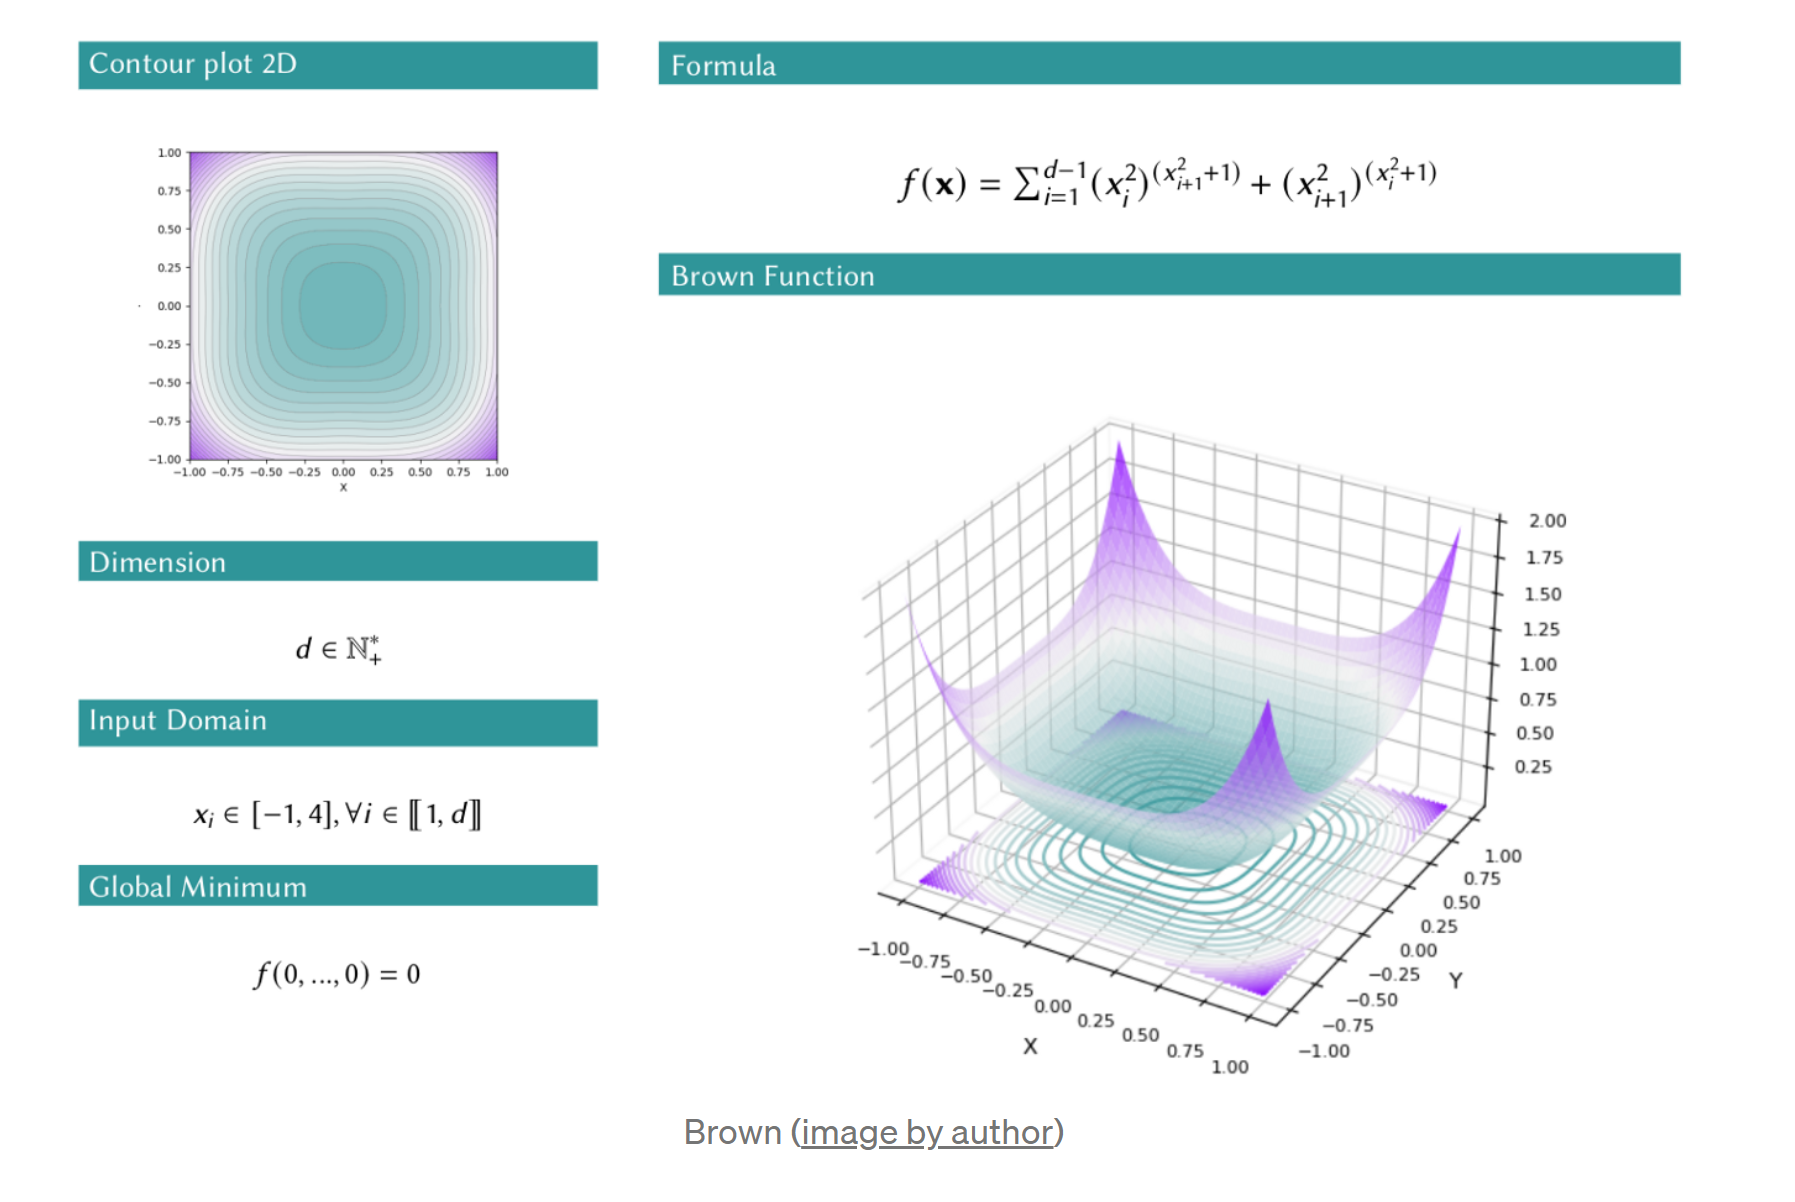

In [14]:
import requests
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image


cmap = [(0, '#2f9599'), (0.45, '#eeeeee'), (1, '#8800ff')]
cmap = cm.colors.LinearSegmentedColormap.from_list('Custom', cmap, N=256)


def latex_img(latex):
    base_url = r'https://latex.codecogs.com/png.latex?\dpi{400}\\'
    url = f'{base_url}{latex}'
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img


def plot_2d(function, n_space=1000, cmap=cmap, XYZ=None, ax=None, show=True):
    X_domain, Y_domain = function.input_domain
    if XYZ is None:
        X, Y = np.linspace(*X_domain, n_space), np.linspace(*Y_domain, n_space)
        X, Y = np.meshgrid(X, Y)
        XY = np.array([X, Y])
        Z = np.apply_along_axis(function, 0, XY)
        
    else:
        X, Y, Z = XYZ

    # create new ax if None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

    # add contours and contours lines
    # ax.contour(X, Y, Z, levels=30, linewidths=0.5, colors='#999')
    ax.contourf(X, Y, Z, levels=30, cmap=cmap, alpha=0.7)

    # add labels and set equal aspect ratio
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect(aspect='equal')
    if show:
        plt.show()


def plot_3d(function, n_space=1000, cmap=cmap, XYZ=None, ax=None, show=True):
    X_domain, Y_domain = function.input_domain
    if XYZ is None:
        X, Y = np.linspace(*X_domain, n_space), np.linspace(*Y_domain, n_space)
        X, Y = np.meshgrid(X, Y)
        XY = np.array([X, Y])
        Z = np.apply_along_axis(function, 0, XY)
    else:
        X, Y, Z = XYZ


    # create new ax if None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')

    # Plot the surface.
    ax.plot_surface(X, Y, Z, cmap=cmap,
                           linewidth=0, antialiased=True, alpha=0.7)
    ax.contour(X, Y, Z, zdir='z', levels=30, offset=np.min(Z), cmap=cmap)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.zaxis.set_tick_params(labelsize=8)
    if show:
        plt.show()

In [15]:
class SumDiffPow:
    name = 'SumDiffPow'
    latex_formula = r'f(\mathbf{x}) = \sum_{i=1}^{d}{x_i}^{i+1}}'
    latex_formula_dimension = r'd \in \mathbb{N}_{+}^{*}'
    latex_formula_input_domain = r'x_i \in [-1, 1], \forall i \in \llbracket 1, d\rrbracket'
    latex_formula_global_minimum = r'f(0, ..., 0)=0'
    continuous = True
    convex = True
    separable = False
    differentiable = True
    mutimodal = False
    randomized_term = False
    parametric = False

    @classmethod
    def is_dim_compatible(cls, d):
        assert (d is None) or (isinstance(d, int) and (not d < 0)), "The dimension d must be None or a positive integer"
        return (d is None) or (d  > 0)

    def __init__(self, d=None):
        self.input_domain = np.array([[-1, 1] for _ in range(d)])

    def get_param(self):
        return {}

    def get_global_minimum(self, d):
        X = np.array([0 for _ in range(d)])
        return (X, self(X))

    def __call__(self, X):
        indices = np.arange(1, len(X)+1)
        res = np.sum(np.abs(X)**indices)
        return res

In [16]:
b_func = SumDiffPow(d=2)

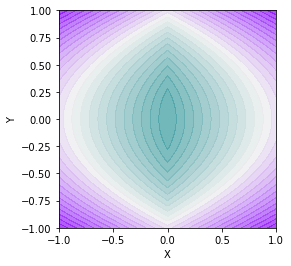

In [17]:
plot_2d(b_func)

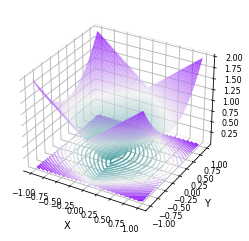

In [18]:
plot_3d(b_func)

In [19]:
black_box_function = SumDiffPow(d=3)

In [40]:
## x has to be in interval [-1, 1]

## converting x to be in this interval from another interval 

# for needle gauge nx ~ [18, 20, 22] -> (nx-20)/2 ~ [-1, 0, 1]
# for speed sx ~ [0.5,2] -> sx-1.5 ~ [-1, 0.5]
# for pressure px ~ [10, 40] -> [px-20]/20 ~ [-0.5, 2]
def point_transformation(x):
    return np.array([(x[0]-20)/2, x[1]-1.5, (x[2]-20)/20])

# global minimum of 0, 0, 0 is now [20, 1.5, 20]

num_initial_points = 8

# this is still random
initial_x = np.array([[18,0.5,10], 
                 [18,0.7,11], 
                 [18,0.9,12], 
                 [20,1.1,13], 
                 [20,1.3,20], 
                 [20,1.5,30], 
                 [21,1.7,40], 
                 [21,1.9,35]
            ])

# this is evaluated with the blackbox function too
initial_x_transformed = np.apply_along_axis(point_transformation, -1, initial_x)
initial_y = np.apply_along_axis(black_box_function, -1, initial_x_transformed)
initial_y = initial_y.reshape((initial_y.shape[0], 1))

initial_data = trieste.data.Dataset(
    tf.constant(initial_x, dtype ='float64'), 
    tf.constant(initial_y, dtype ='float64'))


In [64]:
# acquisition function - something more precise

# method for acquisition optimization
from trieste.acquisition.rule import EfficientGlobalOptimization

from trieste.acquisition import (
    SingleModelAcquisitionBuilder,
    NegativeLowerConfidenceBound,
    Product,
)

lcb = NegativeLowerConfidenceBound(beta=0.01)
rule = EfficientGlobalOptimization(lcb)  # type: ignore

Iteration #0
Ask Trieste for configuration
Trieste took 0.36s to answer
New Configuration to Try # 1
Speed (mm/s):  1.9
Pressure (bars):  15.0
Needle (mm):  22.0
Print configuration:  [[22.   1.9 15. ]] 

Printed material accuracy of [1.175625]


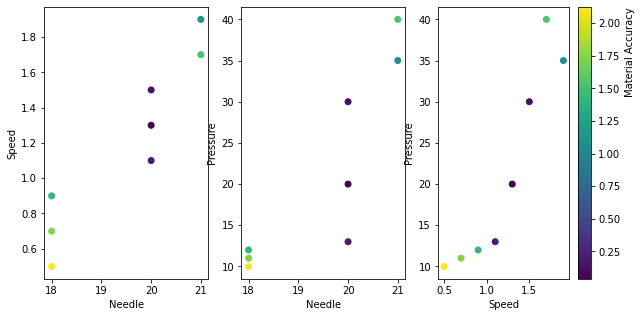

Trieste took 0.91s to tell
Iteration #1
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 2
Speed (mm/s):  0.9
Pressure (bars):  22.0
Needle (mm):  18.0
Print configuration:  [[18.   0.9 22. ]] 

Printed material accuracy of [1.361]


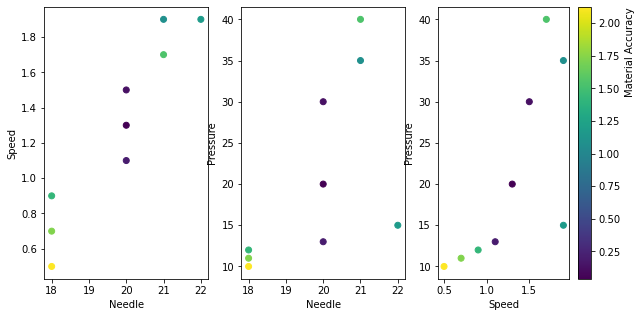

Trieste took 1.12s to tell
Iteration #2
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 3
Speed (mm/s):  1.1
Pressure (bars):  20.0
Needle (mm):  22.0
Print configuration:  [[22.   1.1 20. ]] 

Printed material accuracy of [1.16]


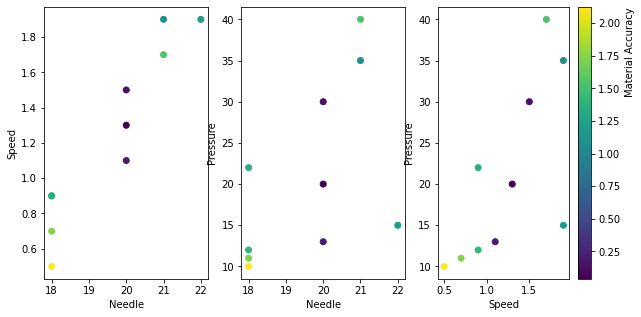

Trieste took 1.13s to tell
Iteration #3
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 4
Speed (mm/s):  1.7
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.7 19. ]] 

Printed material accuracy of [0.040125]


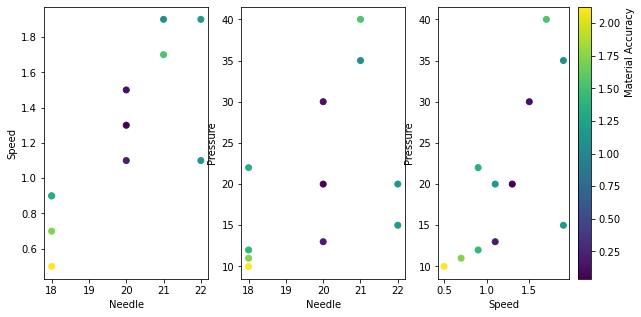

Trieste took 1.63s to tell
Iteration #4
Ask Trieste for configuration
Trieste took 0.01s to answer
New Configuration to Try # 5
Speed (mm/s):  0.5
Pressure (bars):  49.0
Needle (mm):  18.0
Print configuration:  [[18.   0.5 49. ]] 

Printed material accuracy of [5.048625]


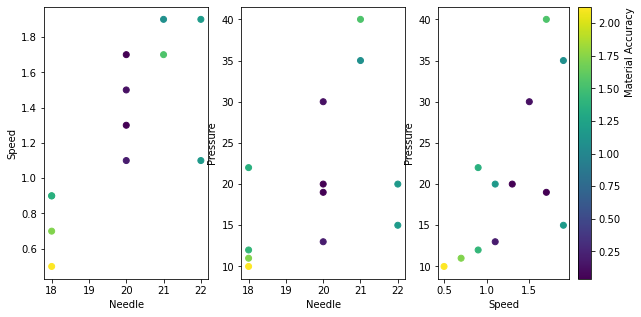

Trieste took 1.00s to tell
Iteration #5
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 6
Speed (mm/s):  1.1
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.1 19. ]] 

Printed material accuracy of [0.160125]


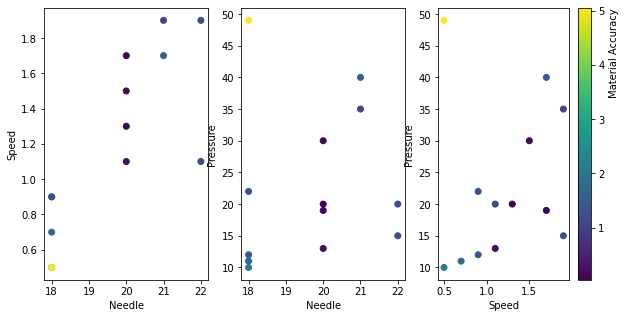

Trieste took 0.97s to tell
Iteration #6
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 7
Speed (mm/s):  1.9
Pressure (bars):  20.0
Needle (mm):  20.0
Print configuration:  [[20.   1.9 20. ]] 

Printed material accuracy of [0.16]


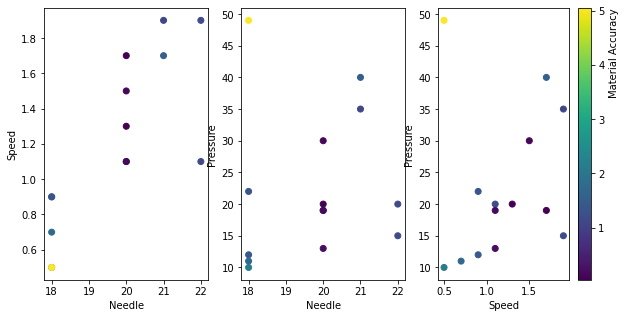

Trieste took 0.99s to tell
Iteration #7
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 8
Speed (mm/s):  1.9
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.9 19. ]] 

Printed material accuracy of [0.160125]


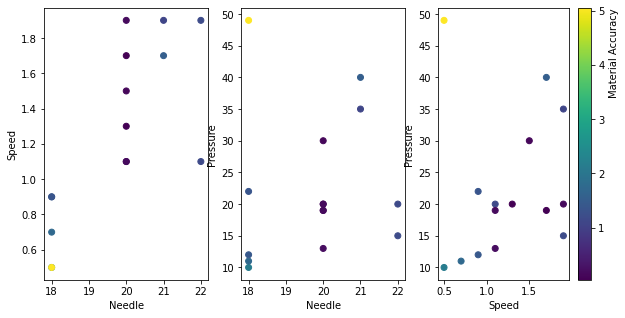

Trieste took 1.01s to tell
Iteration #8
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 9
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


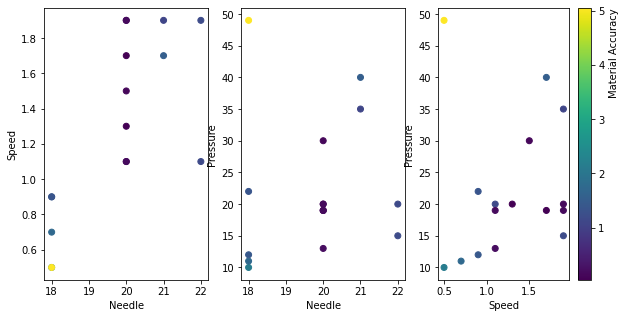

Trieste took 0.99s to tell
Iteration #9
Ask Trieste for configuration
Trieste took 0.01s to answer
New Configuration to Try # 10
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


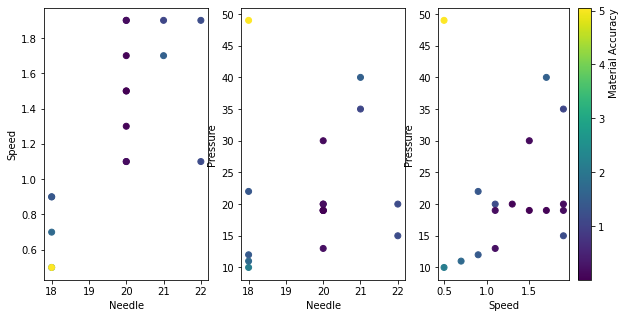

Trieste took 0.97s to tell
Iteration #10
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 11
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


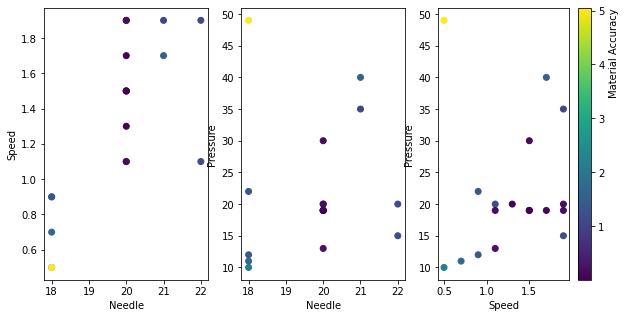

Trieste took 1.02s to tell
Iteration #11
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 12
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


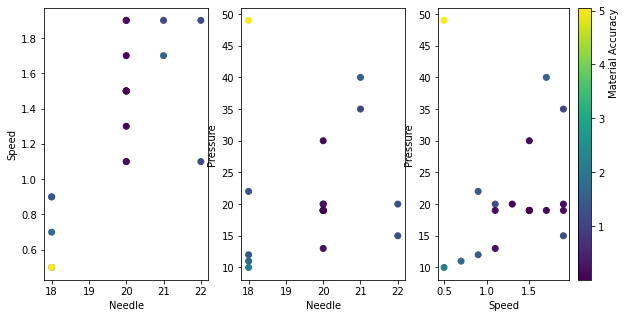

Trieste took 0.93s to tell
Iteration #12
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 13
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


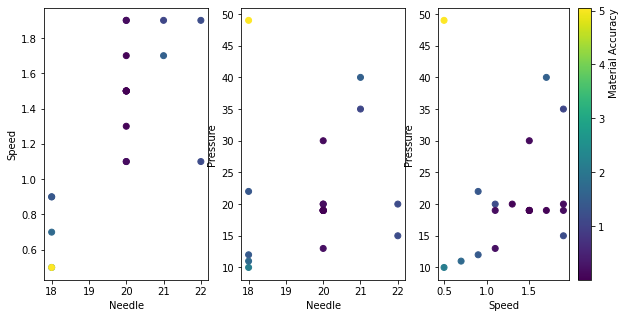

Trieste took 0.91s to tell
Iteration #13
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 14
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


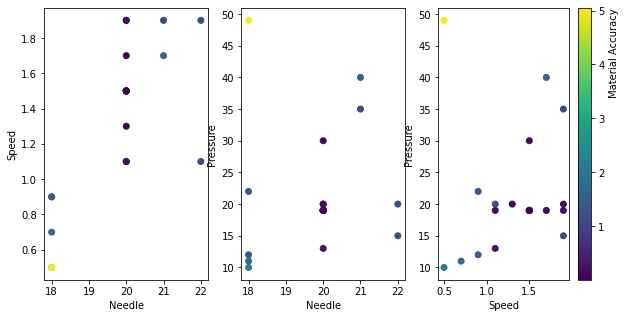

Trieste took 0.93s to tell
Iteration #14
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 15
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


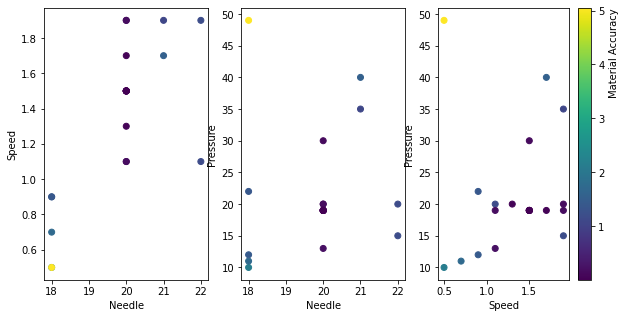

Trieste took 1.28s to tell
Iteration #15
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 16
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


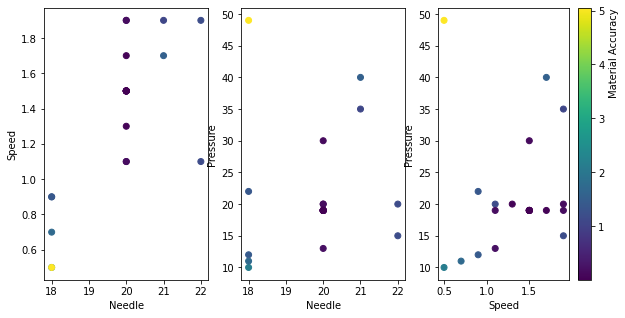

Trieste took 0.96s to tell
Iteration #16
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 17
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


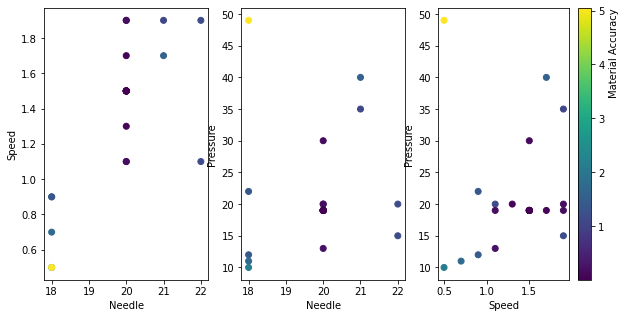

Trieste took 0.95s to tell
Iteration #17
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 18
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


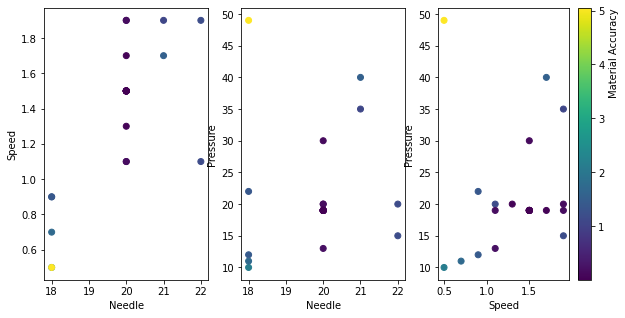

Trieste took 0.99s to tell
Iteration #18
Ask Trieste for configuration
Trieste took 0.01s to answer
New Configuration to Try # 19
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


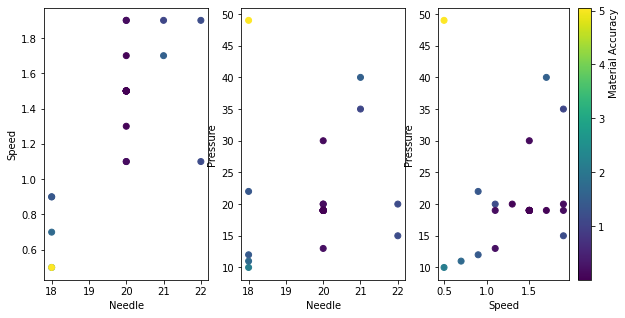

Trieste took 0.99s to tell
Iteration #19
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 20
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


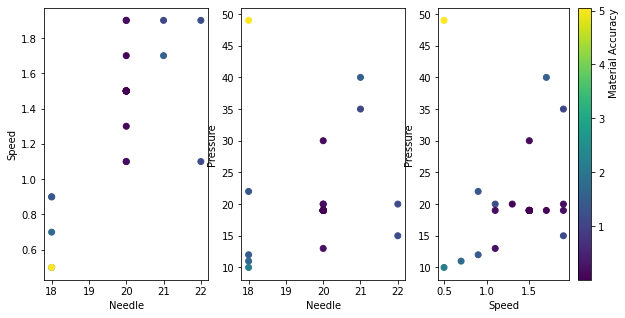

Trieste took 0.97s to tell
Iteration #20
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 21
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


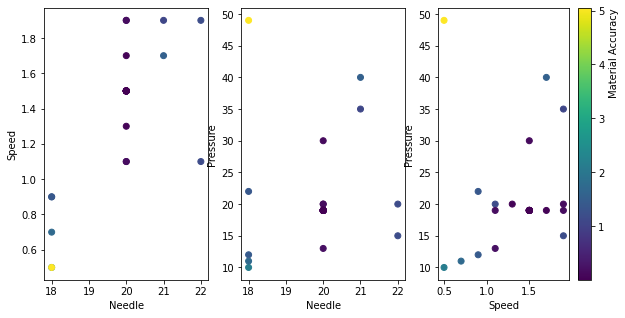

Trieste took 0.97s to tell
Iteration #21
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 22
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


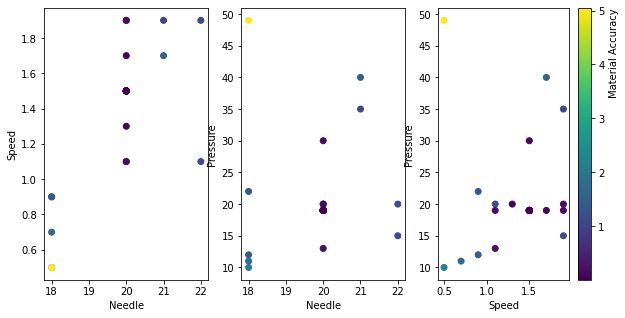

Trieste took 1.29s to tell
Iteration #22
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 23
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


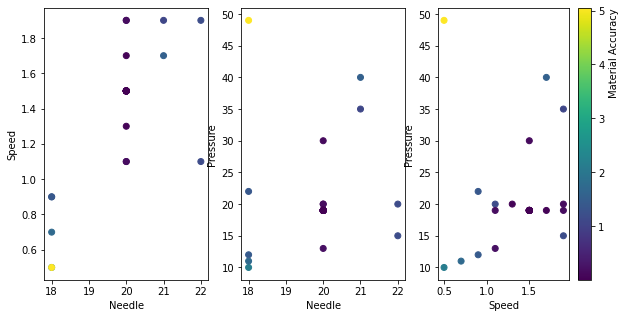

Trieste took 1.28s to tell
Iteration #23
Ask Trieste for configuration
Trieste took 0.01s to answer
New Configuration to Try # 24
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


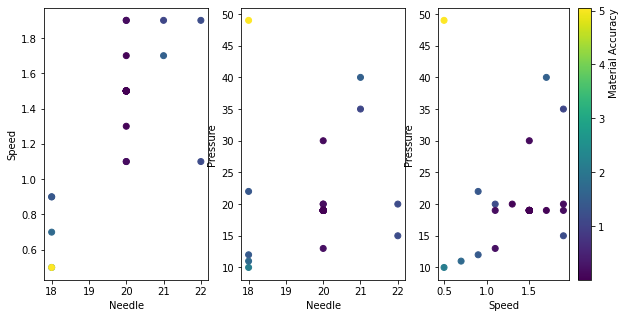

Trieste took 1.16s to tell
Iteration #24
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 25
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


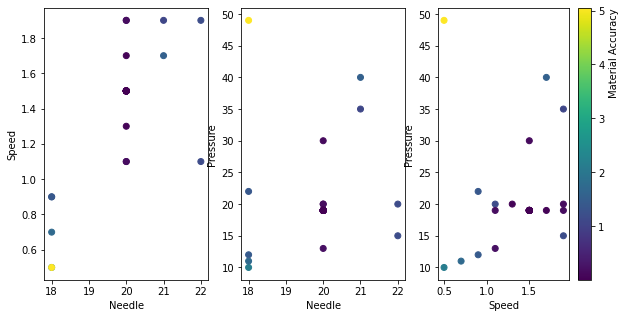

Trieste took 1.05s to tell
Iteration #25
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 26
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


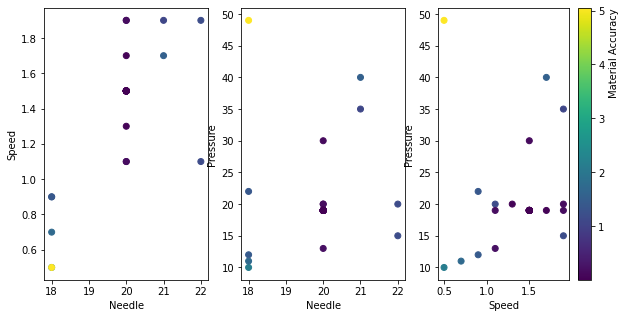

Trieste took 1.12s to tell
Iteration #26
Ask Trieste for configuration
Trieste took 0.00s to answer
New Configuration to Try # 27
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


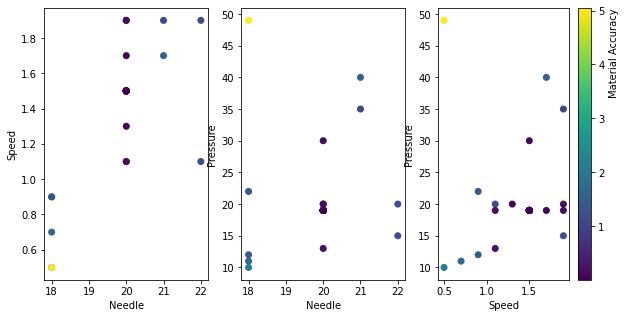

Trieste took 1.15s to tell
Iteration #27
Ask Trieste for configuration
Trieste took 0.01s to answer
New Configuration to Try # 28
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


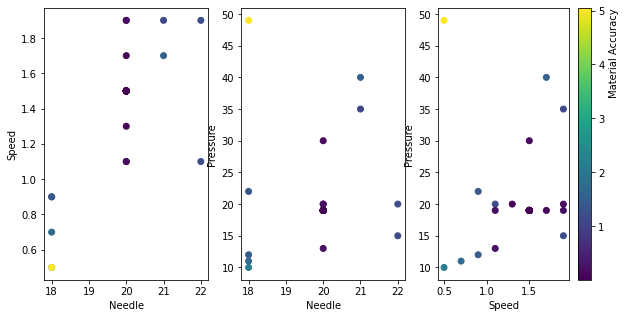

Trieste took 1.51s to tell
Iteration #28
Ask Trieste for configuration
Trieste took 0.01s to answer
New Configuration to Try # 29
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


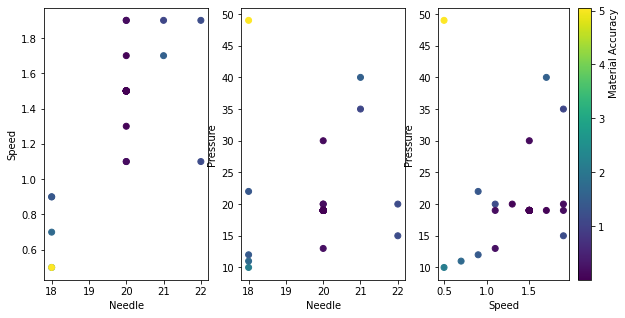

Trieste took 1.42s to tell
Iteration #29
Ask Trieste for configuration
Trieste took 0.01s to answer
New Configuration to Try # 30
Speed (mm/s):  1.5
Pressure (bars):  19.0
Needle (mm):  20.0
Print configuration:  [[20.   1.5 19. ]] 

Printed material accuracy of [0.000125]


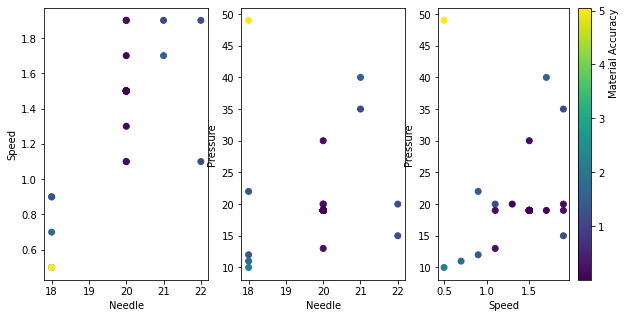

Trieste took 1.29s to tell


In [65]:


# we initialize the gaussian process with this data
model = build_model(initial_data)
# we formulate the ask-tell optimizer
ask_tell = AskTellOptimizer(search_space, initial_data, model, rule)

max_iterations = 30
times_dict = {"num_data":[], "ask_time":[], "tell_time":[]}
answer_dict = {"ng":[], "speed":[], "pressure":[], "material_accuracy":[]}
num_datapoints = initial_x.shape[0]
for i in range(max_iterations):
    print("Iteration #{}".format(i))
    print("Ask Trieste for configuration")
    t1 = time()
    new_config = ask_tell.ask()
    t2 = time()
    ask_time = t2-t1
    
    print("Trieste took {:.2f}s to answer".format(t2-t1))
    for j in range(len(new_config)):
        print('New Configuration to Try #', i + 1)
        ng =  np.round(new_config[j][0].numpy(),1)
        speed = np.round(new_config[j][1].numpy(),1)
        pressure =  np.round(new_config[j][2].numpy(),1)
        print_config = np.array([[ng, speed, pressure]])
        # gotta transform it to fit bb function limits
        print_config_transformed = np.apply_along_axis(point_transformation, -1, print_config)
        print('Speed (mm/s): ', speed)
        print('Pressure (bars): ', pressure)
        print('Needle (mm): ', ng)
        print('Print configuration: ', print_config, '\n')
        # "dummy" printing parameters here (black-box function)
        printed_material_accuracy =  np.apply_along_axis(black_box_function, -1, print_config_transformed)
        print("Printed material accuracy of {}".format(printed_material_accuracy))
        answer_dict["ng"].append(ng)
        answer_dict["speed"].append(speed)
        answer_dict["pressure"].append(pressure)
        answer_dict["material_accuracy"].append(printed_material_accuracy)
        
    plot_ask_tell_results(ask_tell.to_result())
    
    new_input = Dataset(
    tf.constant(print_config),
    tf.constant(np.array([printed_material_accuracy]))
               )
    
    num_datapoints += 1
    t1 = time()
    ask_tell.tell({"OBJECTIVE":new_input})
    t2 = time()
    tell_time = t2-t1
    print("Trieste took {:.2f}s to tell".format(t2-t1))
    times_dict["num_data"].append(num_datapoints)
    times_dict["ask_time"].append(ask_time)
    times_dict["tell_time"].append(tell_time)

In [66]:
results = pd.DataFrame(answer_dict)
results["material_accuracy"] = results["material_accuracy"].apply(lambda x: x[0])
results

ng  speed  pressure  material_accuracy
0   22.0    1.9      15.0           1.175625
1   18.0    0.9      22.0           1.361000
2   22.0    1.1      20.0           1.160000
3   20.0    1.7      19.0           0.040125
4   18.0    0.5      49.0           5.048625
5   20.0    1.1      19.0           0.160125
6   20.0    1.9      20.0           0.160000
7   20.0    1.9      19.0           0.160125
8   20.0    1.5      19.0           0.000125
9   20.0    1.5      19.0           0.000125
10  20.0    1.5      19.0           0.000125
11  20.0    1.5      19.0           0.000125
12  20.0    1.5      19.0           0.000125
13  20.0    1.5      19.0           0.000125
14  20.0    1.5      19.0           0.000125
15  20.0    1.5      19.0           0.000125
16  20.0    1.5      19.0           0.000125
17  20.0    1.5      19.0           0.000125
18  20.0    1.5      19.0           0.000125
19  20.0    1.5      19.0           0.000125
20  20.0    1.5      19.0           0.000125
21  20.0    1.5      19.0           0.000125
22  20.0    1.5      19.0           0.000125
23  20.0    1.5      19.0           0.000125
24  20.0    1.5      19.0           0.000125
25  20.0    1.5      19.0           0.000125
26  20.0    1.5      19.0           0.000125
27  20.0    1.5      19.0           0.000125
28  20.0    1.5      19.0           0.000125
29  20.0    1.5      19.0           0.000125

In [67]:
import plotly.express as px
fig = px.line(results, x=[i for i in range(len(results))], y='material_accuracy', markers=True)
fig.show()

#ng_optimal = 
fig = px.line(results, x=[i for i in range(len(results))], y='ng', markers=True)
fig.show()

fig = px.line(results, x=[i for i in range(len(results))], y='speed', markers=True)
fig.show()

fig = px.line(results, x=[i for i in range(len(results))], y='pressure', markers=True)
fig.show()

### Main take-away:

Time should not be an issue for this dimensionality of the problem!! 
(left to test out with different GP/acquisition hyper-parameters)

### TODO for this workflow:

1. Set up the iterations on one of the given distributions (from the predefined [single objectives](https://secondmind-labs.github.io/trieste/0.12.0/autoapi/trieste/objectives/single_objectives/index.html)) - so that we can better understand what is going on and follow convergence of an actual function (rather than having an imaginary random output always)


2. Plot the speed-needle, pressure-needle views too.


3. Test out the times with different parameters of the inputs.


4. Any other packages we might want to test out? This one has a really bad documentation (from what I have seen) - although it seems to have really good wrapper functions.  


5. Summarize the timing of the experiment - computation in a spreadsheet (set up day 1 - day X experiments with how much material will need to be printed given the convergence etc.)

### TODO general:

Think about other potential problems we might want to address with the feasibility analysis. 

- Summarize **key points from the other BO paper** - this can be a proof of concept besides out initial experiments (it shows that someone else has done it successfully). What were the good sides and what were the potential problems they experienced with BO?


- Think about the material accuracy as the **objective function**: is this the best metric to estimate the quality of the print for your S2.2 and S2.3? are we sure we can rely on it? do we want to think about a multi-objective (a combination of a couple of factors)?


- What to suggest for **other materials from SA2.2/SA2.3**? Should we just say if this works well for SA2.1 it can be applied to other materials during printing too? If not, can always revert to full factorial.


- How to deal with the fact that our outputs are not deterministic? Material accuracy will vary across the experiments. Is there some variation of the BO that can take this into account?


- How to define the target pring quality or maximum number of iteration? How much bio-ink will we have?
